In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from nanodrz.model import DiarizeGPT, Config, quantize, dequantize, enc_label
from nanodrz import data
from nanodrz.data import artificial_diarisation_sample
from nanodrz.utils import visualise_annotation, play
from nanodrz.download import dl_scp_file
from glob import glob
from os import path
import json
from nanodrz.constants import CACHE_DIR
from nanodrz import format_conversions as format
from functools import partial

/home/harry/nanodrz/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


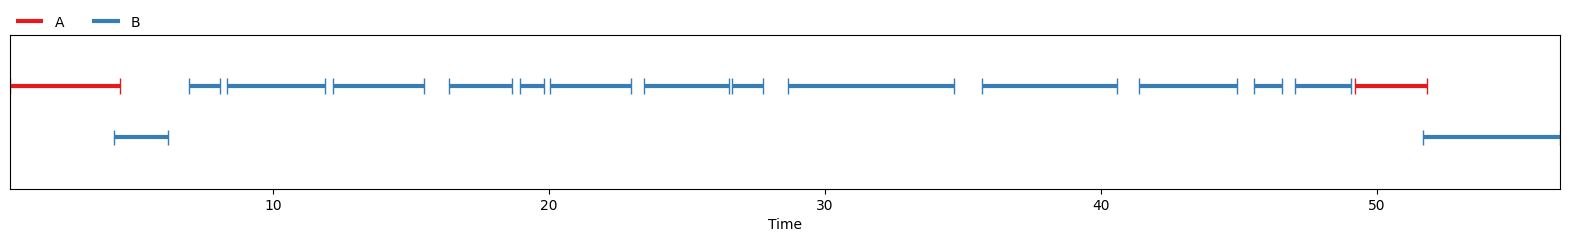

In [3]:
device = torch.device("cuda:0")
torch.cuda.set_device(device)
# https://drive.google.com/file/d/1Cg_GPHxpcWMqGpsDlLMXlr5ui0mPYacn/view?usp=sharing
ckpt = torch.load("/home/harry/runs/nanodrz/1708904995/0014000.pt", map_location=device)
model: DiarizeGPT = DiarizeGPT.from_pretrained(ckpt).cuda()

# Use the same parameters that the model was trained on to generate a sample
audio, labels = artificial_diarisation_sample(
    data.get_speakers(), min_secs=50, num_speakers=2, max_secs=60
)
reference = format.labels_to_annotation(labels)
visualise_annotation(labels)

processed 0


/home/harry/nanodrz/.venv/lib/python3.11/site-packages/torch/functional.py:660: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:874.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


processed 15.0
processed 30.0
processed 45.0


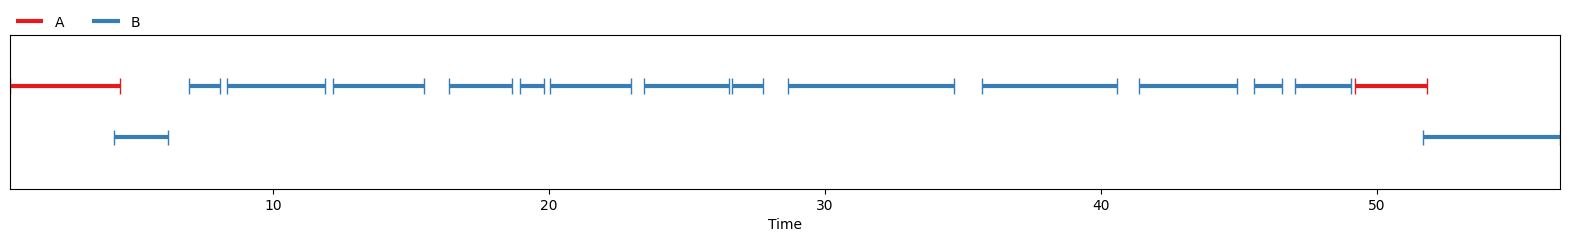

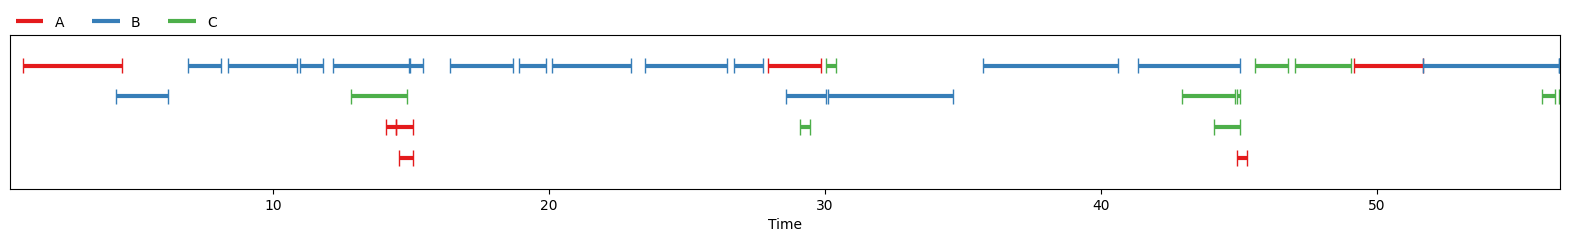

0.3196621543181116


/home/harry/nanodrz/.venv/lib/python3.11/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


In [4]:
# Play with this
temp = 0.3

chunk_length = 15
speaker_samples = {}
sr = 16000
nlabels = []
pad_length = 0.2

q = partial(
    quantize,
    max_seconds=model.config.data.max_secs,
    num_time_tokens=model.num_time_tokens,
)
dq = partial(
    dequantize,
    max_seconds=model.config.data.max_secs,
    num_time_tokens=model.num_time_tokens,
)

processed_audio = 0
for i, chunk in enumerate(audio.split(sr * chunk_length, dim=-1)):
   
    print("processed", processed_audio)

    if i == 0:
        new_labels = model.generate(chunk.cuda(), temperature=temp)
    else:
        prefix_chunk = torch.zeros(1, int(0.1 * sr))
        prefix_labels = []
        for k in speaker_samples.keys():
            cur_len = prefix_chunk.shape[-1] / sr
            sample = speaker_samples[k]
            prefix_chunk = torch.cat(
                (
                    prefix_chunk,
                    speaker_samples[k],
                    torch.zeros(1, int(pad_length * sr)),
                ),
                dim=-1,
            )

            prefix_labels += [
                q(cur_len),
                q(cur_len + sample.shape[-1] / sr),
                enc_label(k, model.num_embs),
            ]

        chunkwprefix = torch.cat((prefix_chunk, chunk), dim=-1)
        prefix_labels = torch.tensor(prefix_labels).long().cuda()
        new_labels = model.generate(
            chunkwprefix.cuda(),
            temperature=temp,
            prefix_labels=prefix_labels,
        )
        
        # Remove prefix time from new_labels
        prefix_chunk_len = prefix_chunk.shape[-1] / sr
        for l in new_labels:
            l[0] += processed_audio - prefix_chunk_len
            l[1] += processed_audio - prefix_chunk_len

    # Check for new speakers
    # Do this every step if there are more than 3 speakers
    if i == 0:
        for l in new_labels:
            if l[2] not in speaker_samples:
                speaker_samples[l[2]] = audio[:, int(l[0] * sr) : int(l[1] * sr)]

    nlabels += new_labels
    processed_audio += chunk.shape[-1] / sr

visualise_annotation(labels)
visualise_annotation(nlabels)

from pyannote.metrics.diarization import DiarizationErrorRate

metric = DiarizationErrorRate()
hypothesis = format.labels_to_annotation(nlabels)
print(metric(reference, hypothesis))